# Options Chain Exploration

This short review shows how we can quickly narrow down our search for potentially valuable trades with a few lines of code.

In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

This function handles a number of things

1. We pull out the 50 day moving average
1. Filter the option for a given expiration date
1. Keep only those put options with a strike under the 50 DMA or 5%
1. We only want this if the put is out of the money (not above stock price)
1. We also want to see the current spread (bid - ask of the option)
1. We also want to look at the premium (the last traded price * 100 shares)
1. Our target will be to make at least 75% of the premium if we make this trade

In [2]:
def clean_puts(option, expiration):
    moving_avg = option.info['fiftyDayAverage']
    df = option.option_chain(expiration)
    puts = df.puts.copy()
    
    is_near_moving_avg = puts['strike'] < moving_avg*1.05
    is_in_the_money = puts['inTheMoney'] == False
    # good_delta = puts['delta'].between(0.2, 0.4)
    
    puts = puts[is_near_moving_avg & is_in_the_money]
    puts['spread'] = puts['bid'] - puts['ask']
    puts['premium'] = puts['lastPrice'] * 100
    puts['target'] = puts['premium'] * 0.75
    puts = puts.sort_values('spread', ascending=False)
    
    projection = ['contractSymbol', 'strike', 'premium', 'target',
        'spread', 'volume', 'openInterest']
    return puts[projection]


## Google for 1/26/2024

We're going to look at the week after the 3rd Friday of the month. The 3rd Friday is when institutional traders make their transactions, but from other analysis, this day looked better (feel free to compare!). 

We print out the top 10 by the tightest spread. At this point, I want to know there is a good chance of transaction (tight spread) at a bargain stoke price if I get assigned, and I can compare the volume of trading with the open interest existing on this contract.

In [3]:
ticker = "GOOGL" 
opt = yf.Ticker(ticker)

In [4]:
df = clean_puts(opt, '2024-01-26')
df.head(10)

,contractSymbol,strike,premium,target,spread,volume,openInterest
15,GOOGL240126P00122000,122.0,28.0,21.00,-0.02,12.0,67
16,GOOGL240126P00123000,123.0,48.0,36.00,-0.03,3.0,140
8,GOOGL240126P00115000,115.0,12.0,9.00,-0.03,23.0,67
23,GOOGL240126P00130000,130.0,80.0,60.00,-0.03,56.0,362
18,GOOGL240126P00125000,125.0,38.0,28.50,-0.03,31.0,245
21,GOOGL240126P00128000,128.0,61.0,45.75,-0.04,6.0,218
20,GOOGL240126P00127000,127.0,50.0,37.50,-0.04,12.0,215
19,GOOGL240126P00126000,126.0,43.0,32.25,-0.04,43.0,102
11,GOOGL240126P00118000,118.0,25.0,18.75,-0.04,21.0,32
5,GOOGL240126P00100000,100.0,5.0,3.75,-0.04,1.0,82


## Visualization

Here I want to visualize what was looked at above. I'll plot for each strike price the volume. The larger the bar, the more transactions at that strike price. But I'm also interested in my premium. This is printed on the end of the bar, and is basically monotonically decreasing, but we can compare whether a given return will be a big change from the strike price near it and how the volume is trading at that point.

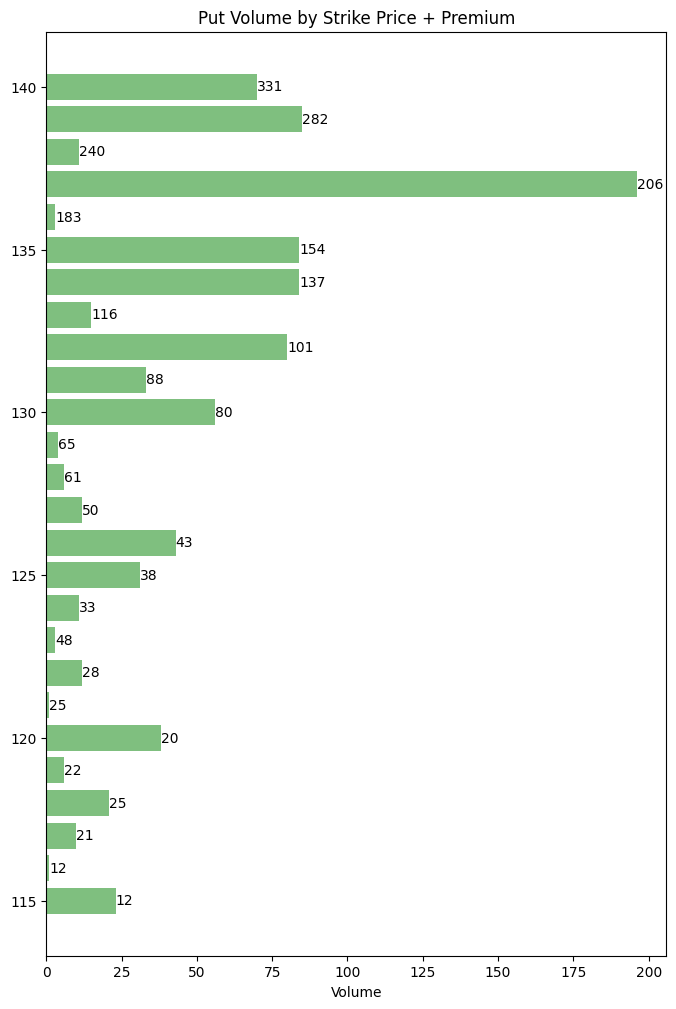

In [23]:
fig, ax = plt.subplots(figsize=(8, 12))
puts = df[df['strike']>=115].sort_values("strike")

ax.barh(puts['strike'], puts['volume'], color='g', alpha=0.5)
x = 5
for index, row in puts.iterrows():
    y = row['strike']
    label = f"{row['premium']:.0f}"
    ax.text(row['volume'], y, label, va='center')

ax.set_xlabel('Volume')
ax.set_title('Put Volume by Strike Price + Premium')

plt.show()

At this point, a rough but quick snapshot of why we might enter one of these trades is here. I might even aim for selling the 134 strike. More volume than the 133 and much more premium than the 132, which the 50 DMA is around 133 right now. I might even entertain the 135, once I look at the greeks (delta around 30%, ideally).

More work would include looking at changing trends in the underlying stock, comparing different expirations, and tracking the value of any given strike price to see how it's been changing. 